In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [20]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, 128)
        self.fc2 = nn.Linear(128, n_out)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)


class CriticNetwork(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.fc1 = nn.Linear(n_in, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [161]:
def run_episode(env, policy: PolicyNetwork, stochastic=True, max_steps=99999) -> tuple:
    states = []
    actions = []
    rewards = []
    state, _ = env.reset()
    for steps in range(1, max_steps+1):
        x = torch.as_tensor(state, dtype=torch.float)
        with torch.no_grad():
            action_probs = policy(x)
        if stochastic:
            action = torch.multinomial(action_probs, 1).item()  # sample 1 action from the (discrete) probability distribution
        else:
            action = action_probs.argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        # if terminated: reward = 0  # sutton_barto_reward kinda
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = next_state
        if terminated or truncated:
            break
    return np.array(states), np.array(actions), np.array(rewards), steps

In [142]:
def calc_returns(rewards: torch.tensor, gamma: int) -> torch.tensor:
    """Calculates discounted return (G_t) at every timestep t using `rewards` from a rollout"""
    T = len(rewards)
    discounted = torch.zeros(T)
    r = 0
    for t in reversed(range(T)):
        r = rewards[t] + gamma * r
        discounted[t] = r
    return discounted

In [143]:
policy = PolicyNetwork(4, 2)  # cartpole: (4,)-continuous observation space, (2,)-discrete action space
critic = CriticNetwork(4)

In [168]:
try: env.reset(), env.close()
except: pass
env = gym.make('CartPole-v1')

In [145]:
gamma = 0.99
lr = 0.001
policy_optimizer = optim.Adam(policy.parameters(), lr=lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=lr)

time 249.11 s


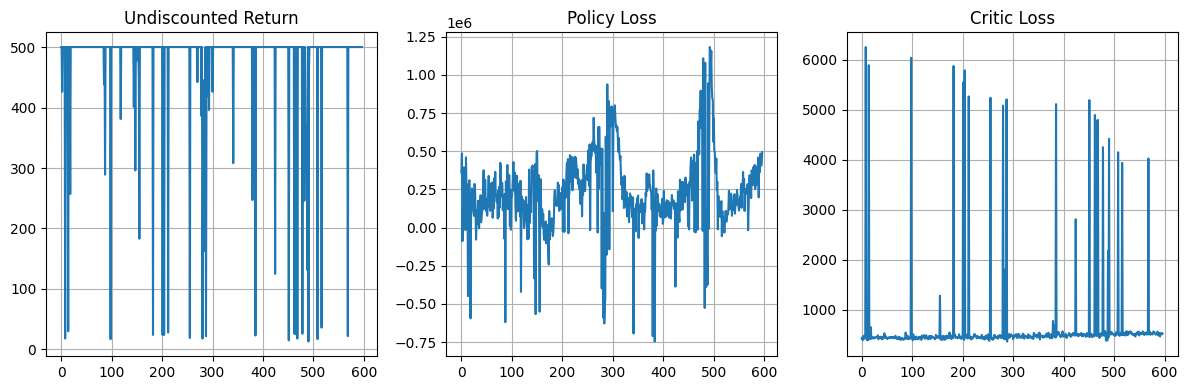

-


In [169]:
undiscounted_history = []
policy_loss_history = []
critic_loss_history = []
try:
    last_plot_update = time.time()
    t0 = time.time()
    for episode in range(1, 3000+1):
        state, _ = env.reset()
        states, actions, rewards, steps = run_episode(env, policy)
        states = torch.as_tensor(states)                   # [T, 4] where T = total timesteps
        actions = torch.as_tensor(actions).reshape(-1, 1)  # [T, 1]
        rewards = torch.as_tensor(rewards)                 # [T]
        
        values = critic(states).squeeze()  # [T]
        
        returns = calc_returns(rewards, gamma=gamma)  # discounted returns for each timestep i.e. list of G_0, G_1, ..., G_{T-1}
        advantages = returns - values.detach()  # make sure that actor backward does not affect critic
        
        # policy (actor) loss
        action_probs = policy(states)
        log_probs = torch.log(action_probs.gather(1, actions))
        policy_loss = -(log_probs * advantages).sum()
        
        # critic loss
        critic_loss = F.mse_loss(values, returns)  # critic trained on Monte Carlo return
        
        policy_optimizer.zero_grad()
        policy_loss.backward()
        # torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        policy_optimizer.step()
        
        critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
        critic_optimizer.step()
                
        undiscounted_history.append(rewards.sum().item())
        policy_loss_history.append(policy_loss.item())
        critic_loss_history.append(critic_loss.item())
        
        if time.time() - last_plot_update > 2:
            last_plot_update = time.time()
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].plot(undiscounted_history)
            axes[0].set_title("Undiscounted Return")
            axes[1].plot(policy_loss_history)
            axes[1].set_title("Policy Loss")
            axes[2].plot(critic_loss_history)
            axes[2].set_title("Critic Loss")
            for ax in axes: ax.grid()
            plt.tight_layout()
            
            clear_output(wait=True)
            print(f'time {time.time() - t0:.2f} s')
            plt.show()            
            
except KeyboardInterrupt:
    print('-')

In [147]:
env.close()

In [171]:
# play
env = gym.make('CartPole-v1', render_mode='human')
_, _, _, steps = run_episode(env, policy, stochastic=False)  # can change to a deterministic policy if desired
print('total steps', steps)
env.close()

total steps 500


In [170]:
# save
import os
os.makedirs('./saved/tstr1/tstr2', exist_ok=True)
torch.save(policy.state_dict(), './saved/CartPole.pth')